## Fine Tunning a Model

In [3]:
from datasets import load_dataset 

dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")

Found cached dataset parquet (/Users/kevinkang/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


### Preproccessing

In [4]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [6]:
#reduce the size of the dataset
dataset = dataset.select(range(100))

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)

### Fine-tunning Model

In [7]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 12.007499694824219
Loss: 10.460878372192383
Loss: 9.950218200683594
Loss: 9.66929817199707
Loss: 9.416208267211914
Loss: 9.215850830078125
Loss: 9.0535888671875
Loss: 8.858267784118652
Loss: 8.696202278137207
Loss: 8.574555397033691
Loss: 8.441370964050293
Loss: 8.32663631439209
Loss: 8.224608421325684
Epoch: 1
Loss: 8.10120964050293
Loss: 7.999195575714111
Loss: 7.922101020812988
Loss: 7.796715259552002
Loss: 7.70510196685791
Loss: 7.604673862457275
Loss: 7.504220008850098
Loss: 7.403675556182861
Loss: 7.301833629608154
Loss: 7.2112298011779785
Loss: 7.102230548858643
Loss: 7.010686874389648
Loss: 6.903541088104248
Epoch: 2
Loss: 6.802009582519531
Loss: 6.70596170425415
Loss: 6.602794647216797
Loss: 6.502535343170166
Loss: 6.391055107116699
Loss: 6.296682834625244
Loss: 6.183549404144287
Loss: 6.080772399902344
Loss: 5.963228702545166
Loss: 5.859626293182373
Loss: 5.757812023162842
Loss: 5.650420665740967
Loss: 5.556341171264648
Epoch: 3
Loss: 5.430164813995361
Loss: 5.

In [31]:
def generated_caption(image):
    # image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption

In [22]:
#save the mdoel
model.save_pretrained("fine-tuned-model")

### Plotting Examples

In [16]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

In [25]:
from transformers import pipeline

In [28]:
nontuned_model = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [35]:
sample_images_to_visualize = [dataset[i]["image"] for i in range(5)]
finedtuned_captions = [generated_caption(image) for image in sample_images_to_visualize]
nontuned_captions = [nontuned_model(image)[0]["generated_text"] for image in sample_images_to_visualize]

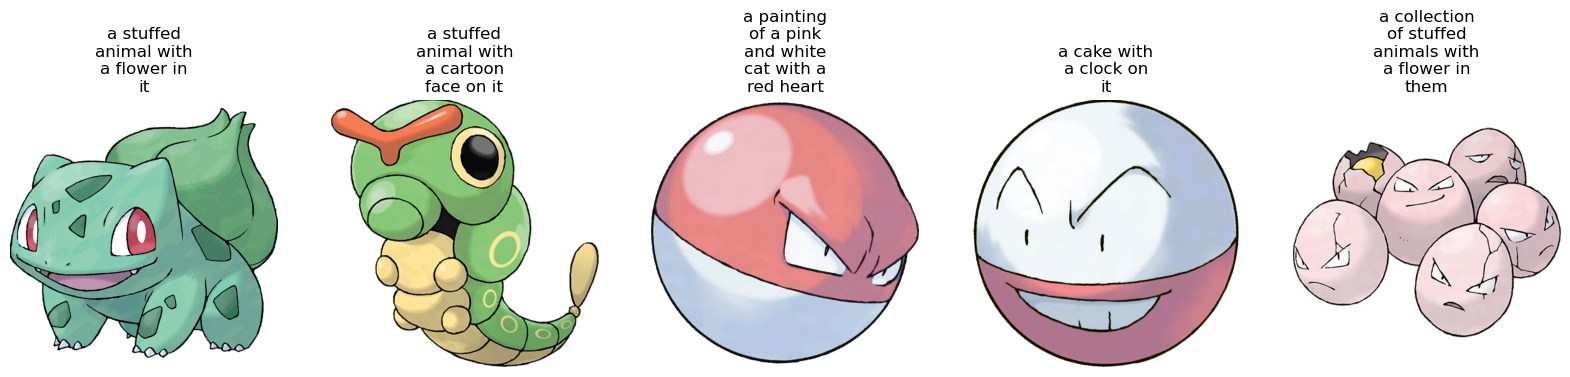

In [37]:
# plotting the nontuned model results
plot_images(sample_images_to_visualize, nontuned_captions)

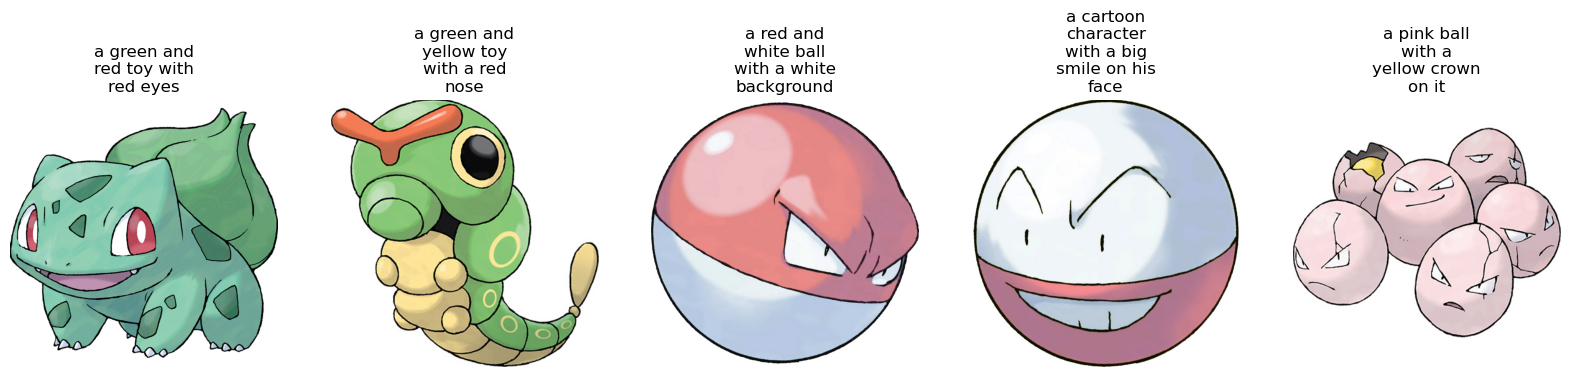

In [38]:
# plotting the finedtuned model results
plot_images(sample_images_to_visualize, finedtuned_captions)

### Testing Efficacy on Pokemon Dataset

In [40]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import random 

In [49]:
dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
dataset.shuffle()

Found cached dataset parquet (/Users/kevinkang/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'text'],
    num_rows: 833
})

In [50]:
# get the bleu score for the nontuned model
nontuned_references = [[item["text"]] for item in dataset]
nontuned_hypotheses = [nontuned_model(item["image"])[0]["generated_text"] for item in tqdm(dataset)]

  0%|          | 0/833 [00:00<?, ?it/s]/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 833/833 [10:21<00:00,  1.34it/s]


In [51]:
nontuned_bleu_score = corpus_bleu(nontuned_references, nontuned_hypotheses)
print("Nontuned BLEU score:", nontuned_bleu_score)

Nontuned BLEU score: 0.32449199163252707


In [52]:
# get the bleu score for the tuned model
finedtuned_references = [[item["text"]] for item in dataset]
finedtuned_hypotheses = [generated_caption(item["image"]) for item in tqdm(dataset)]

100%|██████████| 833/833 [30:36<00:00,  2.20s/it]  


In [53]:
finedtuned_bleu_score = corpus_bleu(finedtuned_references, finedtuned_hypotheses)
print("Finedtuned BLEU score:", finedtuned_bleu_score)

Finedtuned BLEU score: 0.4013357055586784


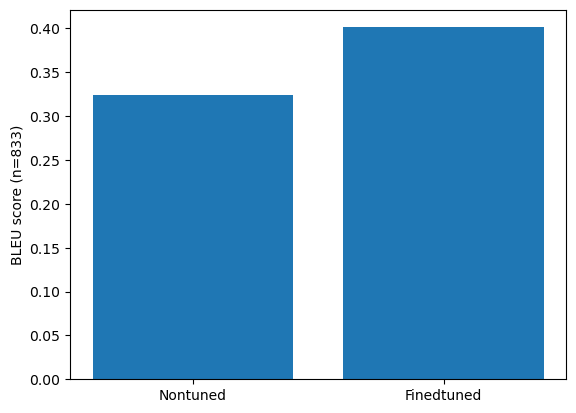

In [54]:
# plot the difference in bleu scores
plt.bar(["Nontuned", "Finedtuned"], [nontuned_bleu_score, finedtuned_bleu_score])
plt.ylabel("BLEU score")
plt.title("BLEU score for nontuned v.s finedtuned models (n=833)")
plt.show()